In [1]:
pip install pandas numpy matplotlib tqdm


Note: you may need to restart the kernel to use updated packages.


Matplotlib is building the font cache; this may take a moment.
Loading price data: 100%|██████████| 101/101 [00:00<00:00, 218.90it/s]


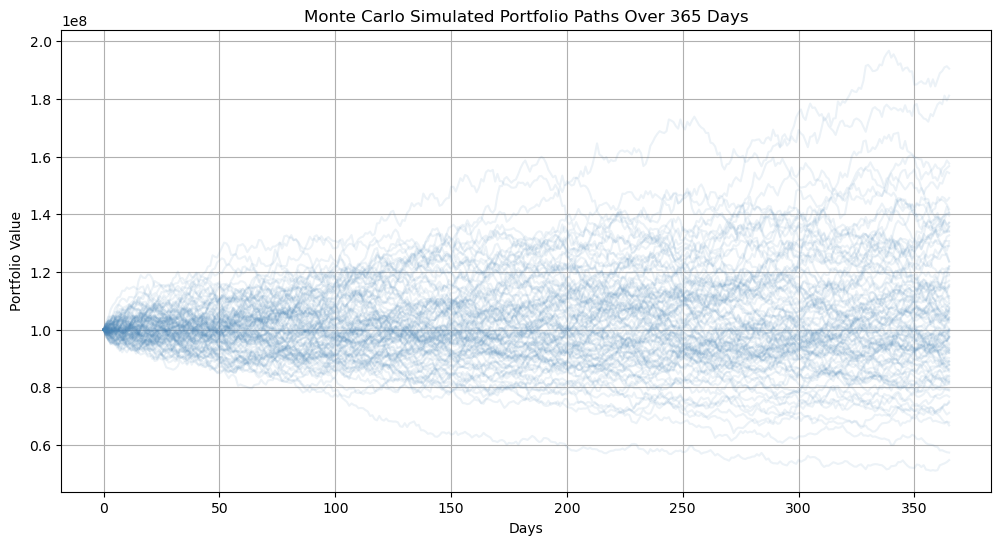

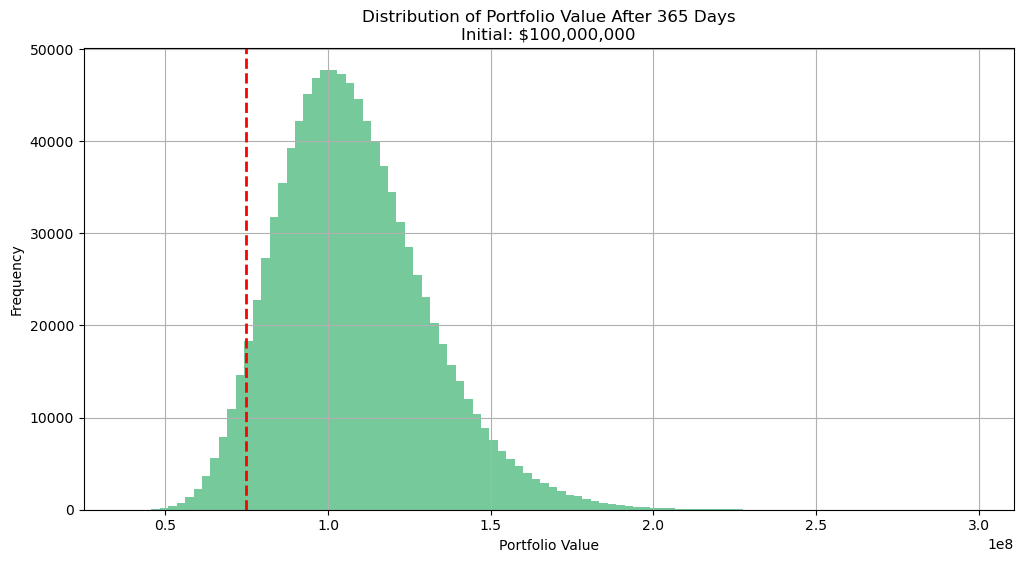

365-Day 95% Value at Risk (VaR): $25,383,536.81

⏱️ Total runtime: 21.67 seconds


In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# === Start Timer ===
start_time = time.time()

# Parameters
tickers_df = pd.read_csv('nasdaq_tickers.csv')
tickers = tickers_df['ticker'].tolist()
data_path = 'stock_data/eod'
initial_portfolio_value = 100_000_000
n_simulations = 1_000_000
n_days = 365
confidence_level = 0.05

# Load adjusted close prices
price_data = {}
for ticker in tqdm(tickers, desc="Loading price data"):
    filepath = os.path.join(data_path, f"{ticker}.csv")
    if os.path.isfile(filepath):
        df = pd.read_csv(filepath, parse_dates=['date'], index_col='date')
        if 'close' in df.columns:
            price_data[ticker] = df['close']
        else:
            print(f"Skipping {ticker} (missing 'close' column)")
    else:
        print(f"File not found: {ticker}.csv")

# Combine and clean
prices = pd.concat(price_data, axis=1).dropna()
log_returns = np.log(prices / prices.shift(1)).dropna()

# Equal-weight portfolio
weights = np.array([1 / len(log_returns.columns)] * len(log_returns.columns))
portfolio_returns = log_returns.dot(weights)

# Mean and std of daily returns
mu = portfolio_returns.mean()
sigma = portfolio_returns.std()

# Monte Carlo Simulation for 365-day horizon
dt = 1  # 1 day time step
simulations = np.zeros((n_days + 1, n_simulations))
simulations[0] = initial_portfolio_value

# Simulate paths using Geometric Brownian Motion
for t in range(1, n_days + 1):
    z = np.random.standard_normal(n_simulations)
    simulations[t] = simulations[t - 1] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z)

# Final values
final_values = simulations[-1]
var_95 = initial_portfolio_value - np.percentile(final_values, 100 * confidence_level)

# === Visualizations ===

# 1. Plot sample paths (only a few for readability)
plt.figure(figsize=(12, 6))
for i in range(100):
    plt.plot(simulations[:, i], alpha=0.1, color='steelblue')
plt.title(f"Monte Carlo Simulated Portfolio Paths Over {n_days} Days")
plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.show()

# 2. Histogram of final portfolio values
plt.figure(figsize=(12, 6))
plt.hist(final_values, bins=100, alpha=0.7, color='mediumseagreen')
plt.axvline(np.percentile(final_values, 100 * confidence_level), color='red', linestyle='--', linewidth=2)
plt.title(f"Distribution of Portfolio Value After {n_days} Days\nInitial: ${initial_portfolio_value:,.0f}")
plt.xlabel("Portfolio Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# 3. Print Value at Risk
print(f"{n_days}-Day 95% Value at Risk (VaR): ${var_95:,.2f}")

# === End Timer ===
end_time = time.time()
elapsed_time = end_time - start_time
print(f"\n⏱️ Total runtime: {elapsed_time:.2f} seconds")


Loading price data: 100%|██████████| 101/101 [00:00<00:00, 134.75it/s]


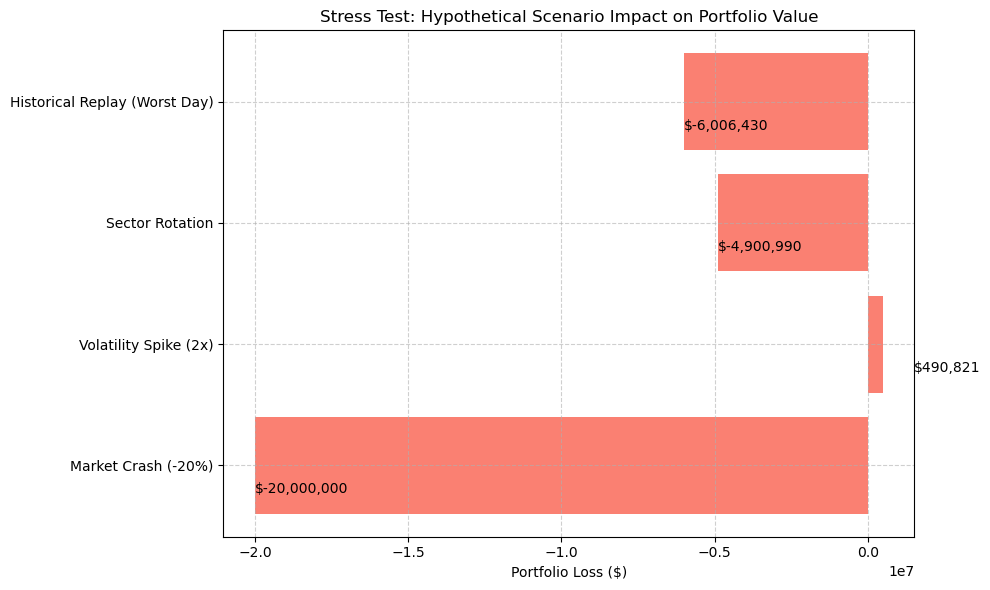

Market Crash (-20%): Portfolio loss = $20,000,000.00 (20.00%)
Volatility Spike (2x): Portfolio loss = $-490,820.90 (-0.49%)
Sector Rotation: Portfolio loss = $4,900,990.10 (4.90%)
Historical Replay (Worst Day): Portfolio loss = $6,006,430.15 (6.01%)


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Parameters
data_path = 'stock_data/eod'
tickers_df = pd.read_csv('nasdaq_tickers.csv')
tickers = tickers_df['ticker'].tolist()
initial_value = 100_000_000

# Load close prices
price_data = {}
for ticker in tqdm(tickers, desc="Loading price data"):
    filepath = os.path.join(data_path, f"{ticker}.csv")
    if os.path.isfile(filepath):
        df = pd.read_csv(filepath, parse_dates=['date'], index_col='date')
        if 'close' in df.columns:
            price_data[ticker] = df['close']
        else:
            print(f"Skipping {ticker} (missing 'close' column)")
    else:
        print(f"File not found: {ticker}.csv")

# Combine into DataFrame
prices = pd.concat(price_data, axis=1).dropna()
log_returns = np.log(prices / prices.shift(1)).dropna()

# Equal weights
n = len(log_returns.columns)
weights = np.array([1/n] * n)

# Portfolio daily returns
portfolio_returns = log_returns.dot(weights)

# Base stats
mu = log_returns.mean()
sigma = log_returns.std()

# === Hypothetical Stress Scenarios ===

def market_crash():
    """All stocks drop 20%"""
    return -0.20 * weights.sum() * initial_value

def volatility_spike():
    """Volatility doubles, simulate 1-day return"""
    simulated = np.random.normal(mu, 2 * sigma)  # 2x vol
    return (1 + simulated.dot(weights)) * initial_value - initial_value

def sector_rotation():
    """Assume first 50% stocks are tech (fall), rest rise"""
    tech_impact = -0.15 * weights[:n//2].sum()
    non_tech_impact = 0.05 * weights[n//2:].sum()
    return (tech_impact + non_tech_impact) * initial_value

def covid_replay():
    """Replay March 16, 2020 or similar worst return day"""
    worst_day = portfolio_returns.idxmin()
    return portfolio_returns.loc[worst_day] * initial_value

# Run all scenarios
scenarios = {
    "Market Crash (-20%)": market_crash(),
    "Volatility Spike (2x)": volatility_spike(),
    "Sector Rotation": sector_rotation(),
    "Historical Replay (Worst Day)": covid_replay()
}

# === Plot ===
plt.figure(figsize=(10, 6))
bars = plt.barh(list(scenarios.keys()), list(scenarios.values()), color='salmon')
plt.xlabel("Portfolio Loss ($)")
plt.title("Stress Test: Hypothetical Scenario Impact on Portfolio Value")

# Annotate
for bar in bars:
    width = bar.get_width()
    plt.text(width if width < 0 else width + 1e6, bar.get_y() + 0.2,
             f"${width:,.0f}", va='center')

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Print Table
for name, loss in scenarios.items():
    print(f"{name}: Portfolio loss = ${-loss:,.2f} ({-loss/initial_value:.2%})")


Pricing options (100d): 100%|██████████| 101/101 [00:01<00:00, 79.29it/s]


Saved option prices to results/option_prices_100d.csv


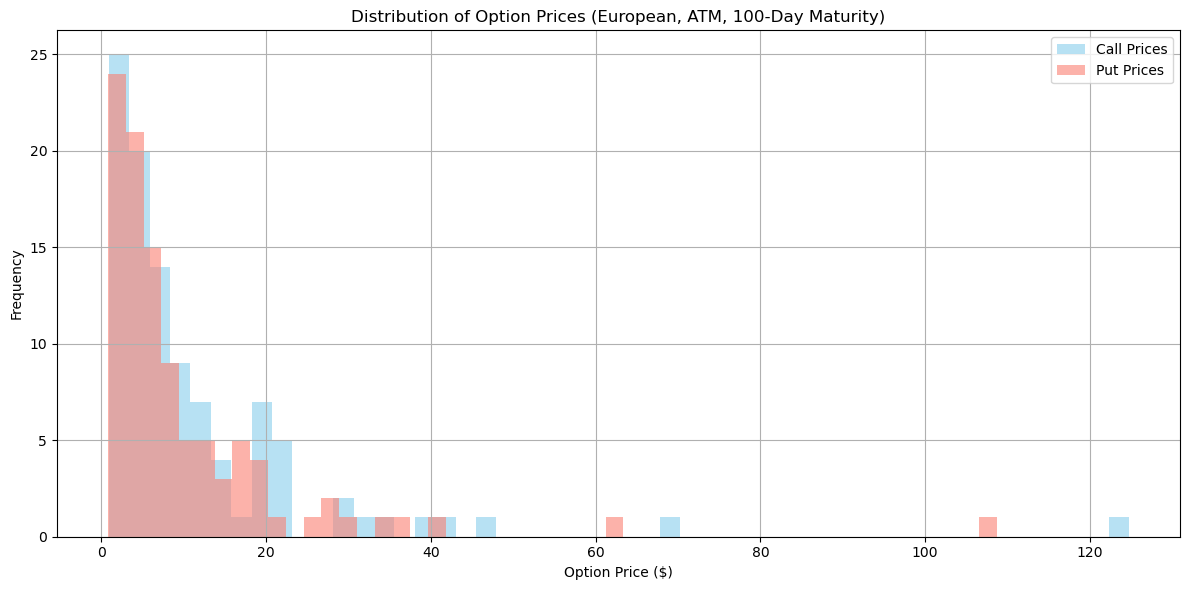

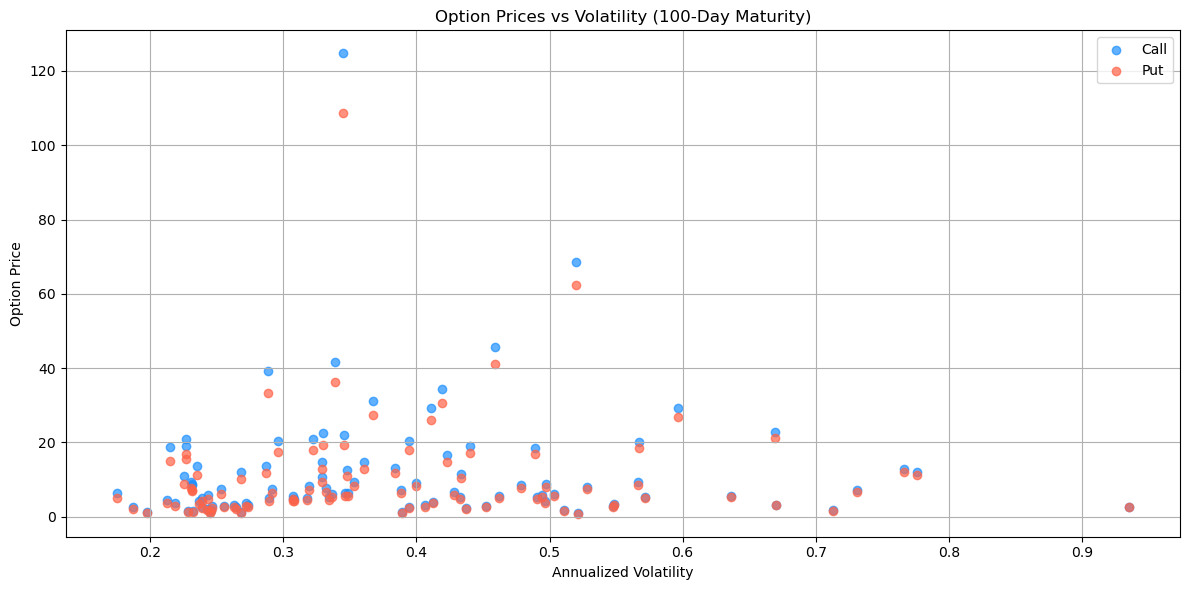

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import norm

# === Black-Scholes Formula ===
def black_scholes(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T) + 1e-8)
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be 'call' or 'put'")
    return price

# === Load Stock Data ===
data_path = 'stock_data/eod'
tickers_df = pd.read_csv('nasdaq_tickers.csv')
tickers = tickers_df['ticker'].tolist()

# Risk-free rate & 100-day maturity
r = 0.03  # 3% annual risk-free
T = 100 / 252  # ~100 trading days

option_data = []

for ticker in tqdm(tickers, desc="Pricing options (100d)"):
    filepath = os.path.join(data_path, f"{ticker}.csv")
    if not os.path.isfile(filepath):
        print(f"{ticker} file missing")
        continue
    df = pd.read_csv(filepath, parse_dates=['date'], index_col='date')
    if 'close' not in df.columns:
        continue
    closes = df['close'].dropna()
    if len(closes) < 60:
        continue
    S = closes.iloc[-1]
    K = S  # ATM
    log_returns = np.log(closes / closes.shift(1)).dropna()
    sigma = log_returns.std() * np.sqrt(252)

    call_price = black_scholes(S, K, T, r, sigma, option_type='call')
    put_price = black_scholes(S, K, T, r, sigma, option_type='put')

    option_data.append({
        'ticker': ticker,
        'spot_price': S,
        'strike_price': K,
        'volatility': sigma,
        'call_price': call_price,
        'put_price': put_price
    })

# === Save to Folder ===
results_folder = 'results'
os.makedirs(results_folder, exist_ok=True)
csv_path = os.path.join(results_folder, 'option_prices_100d.csv')

option_df = pd.DataFrame(option_data)
option_df.to_csv(csv_path, index=False)
print(f"Saved option prices to {csv_path}")

# === Plotting ===
plt.figure(figsize=(12, 6))
plt.hist(option_df['call_price'], bins=50, alpha=0.6, label='Call Prices', color='skyblue')
plt.hist(option_df['put_price'], bins=50, alpha=0.6, label='Put Prices', color='salmon')
plt.title("Distribution of Option Prices (European, ATM, 100-Day Maturity)")
plt.xlabel("Option Price ($)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter Plot: Option Price vs Volatility
plt.figure(figsize=(12, 6))
plt.scatter(option_df['volatility'], option_df['call_price'], alpha=0.7, label='Call', color='dodgerblue')
plt.scatter(option_df['volatility'], option_df['put_price'], alpha=0.7, label='Put', color='tomato')
plt.title("Option Prices vs Volatility (100-Day Maturity)")
plt.xlabel("Annualized Volatility")
plt.ylabel("Option Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
